#1. Đọc về cbow, skip-gram, mô tả cách xây dựng, train 2 mô hình, so sánh ưu nhược điểm. https://www.analyticsvidhya.com/.../word-embeddings.../

Word2vec là phương pháp Word Embedding dựa trên Prediction thay vì Frequency  và đồng thời nó cũng mang lại hiệu quả tốt hơn hẳn so với các phương pháp trước đó. 

Word2vec là một sự kết hợp của 2 kỹ thuật là CBOW (Continuous Bag of Words) và Skip-gram model. Cả 2 mô hình đều là mạng neuron nông thực hiện nhiệm vụ ánh xạ words thành words.

##a. Mô hình CBOW

Phương pháp hoạt động của CBOW đó là thực hiện dự đoán xác suất xuất hiện của một từ dựa trên ngữ cảnh cho trước. Ngữ cảnh có thể là một hoặc nhiều context words kết hợp với nhau nhưng thông thường để đơn giản thì sẽ chỉ sử dụng 1 context word.

Ban đầu, từ bộ dữ liệu là các văn bản đầu vào, ta định nghĩa một context window (thể hiện rằng từ nào sẽ được coi là context đối với đang xét) bao gồm kích thước và chiều. Ví dụ nếu context window có kích thước 1 và theo cả 2 chiều thì trong nó có dạng như sau: 'Đây là một câu ví (dụ **cho** tình) huống trên.' Nếu xét từ 'cho' thì 2 từ 'dụ' và 'tình' là context word của nó. 

Với context window đã được định nghĩa từ trước, ta xác định các cặp (input, output) với input là các context word và output là word cần xác định từ bộ dữ liệu văn bản gốc.

Tiếp theo, định nghĩa một từ điển (vocab) chứa tất cả các word xuất hiện trong training set và thực hiện one-hot tất cả bộ dữ liệu training để đưa hết dạng text về dạng só, dạng mà máy tính có thể xử lý tính toán được.

Mô hình mạng CBOW thông thường sẽ bao gồm 3 layer là input layer, output layer và một hidden layer.

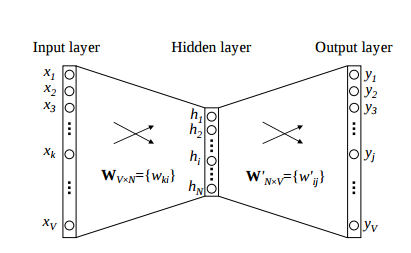

Sau khi thực hiện huấn luyện xong mô hình thi ma trận trọng số giữa hidden layer và output layer sẽ được giữ lại và được coi như là embedding cho mỗi word trong dictionary.

Trong trường hợp có nhiều context word, ví dụ 3 context word thì 3 word đó cũng sẽ được đưa qua vào hidden layer và tạo ra 3 đầu ra từ hidden layer đó. Sau đó nó sẽ thực hiện tính trung bình trên tất cả đầu ra và đưa nó vào layer output.

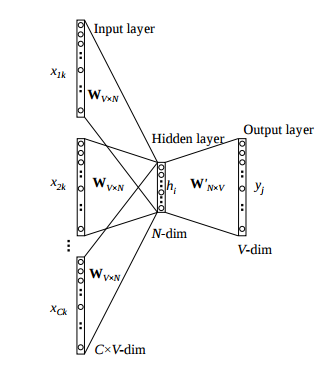

##b. Skip-gram

Mô hình Skip-gram có cấu trúc giống hệt với CBOW, chỉ khác là nó thay đổi thứ tự của đầu vào và đầu ra. Tức là nó sẽ đoán context dựa trên word đã được đưa vào từ trước. Context có thể gồm một hoặc nhiều words. Hơn nữa, sau khi train xong mô hình, người ta sẽ giữ lại ma trận hệ sô giữa input layer và hidden layer làm word embedding của toàn bộ thư viện.

Trong trường hợp có nhiều context word.

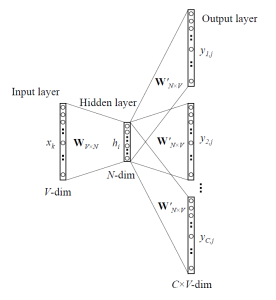

##c. So sánh 2 mô hình

1. Mô hình skip-gram có thể bắt được nhiều ngữ nghĩa của một từ trong quá trình huấn luyện. Mỗi ngữ nghĩa đó sẽ được thể hiện bằng một vector khác nhhau. Ví dụ là Apple sẽ có 2 ngữ nghĩa là một loại trái cây và một loại công ty. Trong khi đó, CBOW sẽ tiến hành cộng và chia trung bình các ngữ nghĩa đó làm cho Apple thành một điểm nằm giữa trái cây và công ty.

2. Cả 2 phương pháp đều tốn ít bộ nhớ RAM bởi vì nó chỉ cần lưu trữ 4 ma trận lớn.

3. Việc tìm word từ context (CBOW) khó hơn việc tìm context từ word (skip-gram) nhiều. Vì vậy, việc train model CBOW nếu không tối ưu cẩn thận thì sẽ không bao giờ hội tụ.

#2. Đọc hiểu và chạy lại code: https://keras.io/examples/nlp/lstm_seq2seq/

In [2]:
# import thư viện
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [5]:
# Tải dữ liệu
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [3]:
# Tham số
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000 # số mẫu dùng để train
data_path = 'fra.txt'

In [6]:
# Chuẩn bị dữ liệu
input_texts = []
target_texts = []
input_characters = set() # loại bỏ trùng lặp
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text, _ = line.split('\t') # sử dụng tab làm startseq cho target và dùng \n là endseq
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples: ', len(input_texts))
print('Number of unique input tokens: ', num_encoder_tokens)
print('Number of unique output tokens: ', num_decoder_tokens)
print('Max sequence length for inputs: ', max_encoder_seq_length)
print('Max sequence length for outputs: ', max_decoder_seq_length)

Number of samples:  10000
Number of unique input tokens:  71
Number of unique output tokens:  92
Max sequence length for inputs:  15
Max sequence length for outputs:  59


In [7]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype = 'float32'
)

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype = 'float32'
)

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype = 'float32'
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  encoder_input_data[i, t+1:, input_token_index[" "]] = 1.0
  for t, char in enumerate(target_text):
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0: # decoder_target_data sớm hơn decoder_input_data 1 timestep do không bao gồm ký tự bắt đầu
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
  decoder_input_data[i, t+1:, target_token_index[' ']] = 1.0
  decoder_target_data[i, t:, target_token_index[' ']] = 1.0

In [11]:
# địng nghĩa phần input
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoer_outputs, state_h, state_c = encoder(encoder_inputs)

# loại bỏ output và chỉ giữ lại state
encoder_states = [state_h, state_c]

# set up decoder, sửu dụng encoder_states làm initial state
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# Set up decoder  để trả về một câu output hoàn chỉnh và trả bề trạng thái bên trong
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# model sẽ chuyển encoder_input_data và decoder_input_dât thành decoder_target_data
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 335872      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  357376      input_4[0][0]                    
                                                                 lstm_2[0][1]               

In [13]:
# train model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.001, verbose=1)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=0.2,
    callbacks=[es]
)

# save model
model.save('s2s')

Epoch 1/100
125/125 [==============================] - 9s 51ms/step - loss: 1.1386 - accuracy: 0.7368 - val_loss: 1.0263 - val_accuracy: 0.7241
Epoch 2/100
125/125 [==============================] - 5s 44ms/step - loss: 0.8140 - accuracy: 0.7805 - val_loss: 0.8347 - val_accuracy: 0.7698
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 0.6483 - accuracy: 0.8172 - val_loss: 0.6904 - val_accuracy: 0.8027
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 0.5691 - accuracy: 0.8347 - val_loss: 0.6285 - val_accuracy: 0.8135
Epoch 5/100
125/125 [==============================] - 5s 38ms/step - loss: 0.5209 - accuracy: 0.8475 - val_loss: 0.5882 - val_accuracy: 0.8311
Epoch 6/100
125/125 [==============================] - 5s 37ms/step - loss: 0.4855 - accuracy: 0.8577 - val_loss: 0.5630 - val_accuracy: 0.8362
Epoch 7/100
125/125 [==============================] - 5s 37ms/step - loss: 0.4575 - accuracy: 0.8644 - val_loss: 0.5342 - val_accuracy:

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [38]:
# define sampling model
model = keras.models.load_model('s2s')

In [40]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_5")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_6")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


In [19]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [41]:
def decode_sequence(input_seq):
  # encode input thành state vector
  states_value = encoder_model.predict(input_seq)

  # Tạo target seq rỗng với độ dãi là 1
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # chuyển ký tự đầu tiên thành tab
  target_seq[0, 0, target_token_index['\t']] = 1.0

  # Sampling loop
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq, states_value])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
    
    # exit condition
    if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
      stop_condition = True

    # update target seq
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    states_value = [h, c]

  return decoded_sentence

In [42]:
for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Attendez.

-
Input sentence: Go.
Decoded sentence: Attendez.

-
Input sentence: Go.
Decoded sentence: Attendez.

-
Input sentence: Hi.
Decoded sentence: Attendez !

-
Input sentence: Hi.
Decoded sentence: Attendez !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Co